In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats  as stats

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold , RandomizedSearchCV , train_test_split 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, precision_score, recall_score ,roc_auc_score,average_precision_score,roc_curve,auc

In [3]:
df = pd.read_csv('Datasets/Bankrupt_in_1year.csv',na_values=['?'])
print(df.shape)


df['class'].value_counts()

(5910, 65)


0    5500
1     410
Name: class, dtype: int64

In [4]:
def data_cleaning(df):
    # Drop columns with missing rate > n
    n = 0.3
    missing  = df.isna().sum().sort_values(ascending = False ) / df.shape[0] 
    imputable_columns = missing[missing < n].keys()
    df = df.loc[:,imputable_columns]
    
    return df
    
def data_preprocessing(df , holdoutratio = 0.01):
    # Create Train fold  and hide Test fold
    test_sample_class = int(df.shape[0] * holdoutratio)

    df_dropNA = df.dropna() #Drop Nan
    Test_Operating  = df_dropNA[df_dropNA['class'] == 0].sample(n=test_sample_class)
    Test_Default    = df_dropNA[df_dropNA['class'] == 1].sample(n=int(test_sample_class/2))


    Test = pd.concat([Test_Default,Test_Operating] , 0) # Create the Hide pure Test Data

    Train = df.loc[~df.index.isin(Test.index), :] # Remove the index of Test and create the Train Block from original df

    Test.sample(frac=1) # Shuffle randomly the Test Block

    return Train , Test

def balanced_sample_traning(df,target = 'class'):
    target = 'class'

    min_sample_size = df[target].value_counts().min()
    positive = df[df[target] == 1].sample(n = min_sample_size)
    negative = df[df[target] == 0].sample(n = min_sample_size)


    Train = pd.concat([positive,negative] , 0).sample(frac=1)

    return Train
    
def Model_Pipeline(df,target = 'class',n_iter = 50,scoring = 'f1',n_splits = 3):
    # Split Predictor and Response
    X  = df.drop('class',1)
    y  = df['class']
    #Initialize Functions for Pipeline
    Clf = XGBClassifier(objective  = 'binary:logistic')
    Kf  = StratifiedKFold(n_splits=n_splits,shuffle=True)
    Imp = KNNImputer()
    #Grid of possible combinations of parameters
    param_dist = {
                  # Imputation params
                  "Imputation__n_neighbors" : [1,3,5],
                  # CLF params
                  "Clf__scale_pos_weight "   : [1, 3, 100] ,
                  "Clf__learning_rate"      : [0.01, 0.1, 0.3] ,
                  "Clf__max_depth"          : [ 3, 5, 6],
                  'Clf__n_estimators'       : [300,800,1000],
                  "Clf__gamma"              : [ 0.0, 0.1, 0.2],
                  "Clf__colsample_bytree"   : [ 0.5,0.7,1 ] 
    }
    # Pipeline Initialization
    pipeline = Pipeline([
                         ('Imputation',Imp),
                         ('Clf', Clf)
                        ])
    # Fit  model and validate model 
    GridS = RandomizedSearchCV(pipeline, 
                               param_distributions = param_dist,
                               cv = Kf,  
                               n_iter = n_iter,
                               scoring = scoring, 
                               error_score = 0, 
                               verbose = 0, 
                               n_jobs = -1)
    GridS.fit(X, y)
    return GridS , GridS.best_estimator_['Clf']
    

def Bankruptcy_Pipe(df):
    
    return 

In [5]:
import time
import warnings
warnings.filterwarnings('ignore')

t0 = time.time()
df = data_cleaning(df)
train , holdout = data_preprocessing(df)
train = balanced_sample_traning(train)
GridS , bestclf = Model_Pipeline(df = train)

t1 = time.time()

exec_time = t1 - t0

[15:42:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { scale_pos_weight  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:42:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [6]:
print('Exec_time: Minutes',exec_time/60)
results = pd.DataFrame(GridS.cv_results_).sort_values('rank_test_score',ascending = True)[['mean_test_score','std_test_score']]
results

Exec_time: Minutes 1.3715044776598613


,mean_test_score,std_test_score
12,0.828821,0.021615
22,0.826310,0.024308
25,0.824067,0.033082
33,0.822129,0.035723
31,0.821983,0.028323
40,0.820950,0.004396
9,0.820175,0.022388
42,0.817772,0.010670
14,0.817359,0.018124
34,0.816270,0.017413


In [7]:
predictors = train.drop('class',1).columns
feature_importances = pd.Series(data  = GridS.best_estimator_['Clf'].feature_importances_ , index = predictors)
feature_importances.sort_values(ascending = False)[:10]

Attr35    0.167004
Attr27    0.047199
Attr38    0.032606
Attr16    0.027961
Attr25    0.025042
Attr21    0.024983
Attr39    0.024474
Attr43    0.023663
Attr46    0.022918
Attr36    0.019369
dtype: float32

In [8]:
GridS.best_estimator_['Clf']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              scale_pos_weight =100, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [9]:
# Unless the confidence of solid business is over 60, declare risk 
predictions  = (bestclf.predict_proba(holdout.drop('class',1).values)[:,1] >= 0.45).astype(int)

f1_score(holdout['class'] , predictions)

0.7636363636363636

In [10]:
train['class'].value_counts()

0    381
1    381
Name: class, dtype: int64

              precision    recall  f1-score   support

           0       0.87      0.92      0.89        59
           1       0.81      0.72      0.76        29

    accuracy                           0.85        88
   macro avg       0.84      0.82      0.83        88
weighted avg       0.85      0.85      0.85        88



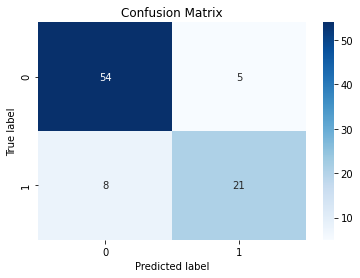

In [11]:
sns.heatmap(confusion_matrix( holdout['class'], predictions) , cmap  = 'Blues', annot = True )
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label');
print(classification_report( holdout['class'], predictions))

# Unsupervised Bankruptcy Prediction with AutoEncoders

In [28]:
df = data_cleaning(df)

train , holdout  = data_preprocessing(df)


def data_preprocessing_autoencoder(df , holdoutratio = 0.01):
    # Create Train fold  and hide Test fold
    test_sample_class = int(df.shape[0] * holdoutratio)

    df_dropNA = df.dropna() #Drop Nan
    Test_Operating  = df_dropNA[df_dropNA['class'] == 0].sample(n=2000)
    Test_Default    = df_dropNA[df_dropNA['class'] == 1].sample(n=50)


    Test = pd.concat([Test_Default,Test_Operating] , 0) # Create the Hide pure Test Data

    Train = df.loc[~df.index.isin(Test.index), :] # Remove the index of Test and create the Train Block from original df

    Test.sample(frac=1) # Shuffle randomly the Test Block

    return Train , Test

train , validate = data_preprocessing_autoencoder(train)

train['class'].value_counts() ,validate['class'].value_counts()

(0    2910
 1     331
 Name: class, dtype: int64,
 0    2000
 1      50
 Name: class, dtype: int64)

In [49]:
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

# configure our pipeline
pipeline = Pipeline([
                     ('Imputation',KNNImputer(n_neighbors=3)),
                     ('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])



X_train    = train.drop('class',1)
X_validate = validate.drop('class',1)



# transform the training and validation data with these parameters
X_train_transformed = pipeline.fit_transform(X_train)
X_validate_transformed = pipeline.fit_transform(X_validate)


# data dimensions // hyperparameters 
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 2**5
EPOCHS = 100

# https://keras.io/layers/core/
autoencoder = tf.keras.models.Sequential([
    
    # deconstruct / encode
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )), 
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(2, activation='elu'),
    
    # reconstruction / decode
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')
    
])

# https://keras.io/api/models/model_training_apis/
autoencoder.compile(optimizer="adam", 
                    loss="mse",
                    metrics=["mse"])

# print an overview of our model
autoencoder.summary();


# Train 
history = autoencoder.fit(
    X_train_transformed, X_train_transformed,
    shuffle=False,
    verbose = False,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_validate_transformed, X_validate_transformed)
);

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 63)                4032      
_________________________________________________________________
dense_37 (Dense)             (None, 16)                1024      
_________________________________________________________________
dense_38 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_39 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_41 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_42 (Dense)             (None, 8)                

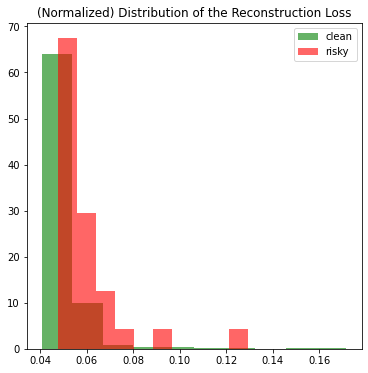

In [77]:
X_test    = holdout.drop('class',1)
y_test    = holdout['class']

X_test_transformed = pipeline.fit_transform(X_test)
reconstructions = autoencoder.predict(X_test_transformed)

mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)

clean  = mse[y_test==0]
risky  = mse[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=10, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=10, density=True, label="risky", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

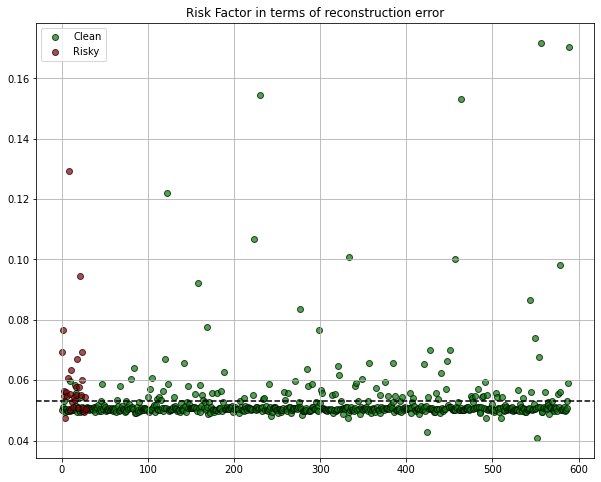

In [100]:

plt.grid(True)
plt.scatter(x = range(len(clean)) ,  y = clean , color = 'green', alpha = 0.7  ,edgecolors = 'k' , label  = 'Clean' )
plt.scatter(x = range(len(risky)) ,  y = risky , color = 'darkred', alpha = 0.7,edgecolors = 'k' , label  = 'Risky' )
plt.legend()
plt.title('Risk Factor in terms of reconstruction error')

risk_cutoff = np.percentile(mse,80)
plt.axhline(y=risk_cutoff, color='k', linestyle='--');

In [113]:
false_positive_rate = (clean[:] > risk_cutoff).astype(int).sum() / len(clean)
round(false_positive_rate,3)

0.175

In [116]:
false_negative_rate = (risky[:] < risk_cutoff).astype(int).sum() / len(risky)
round(false_negative_rate,3)

0.276

In [118]:
true_negative_rate = (clean[:] < risk_cutoff).astype(int).sum() / len(clean)
round(true_negative_rate,3)

0.825

In [119]:
true_positive_rate = (risky[:] > risk_cutoff).astype(int).sum() / len(risky)
round(true_positive_rate,3)

0.724

In [129]:
len(y_test) , len(clean) , len(risky)

(619, 590, 29)

In [124]:
true_positive    =   (risky[:] > risk_cutoff).astype(int).sum()
true_negative    =   (clean[:] < risk_cutoff).astype(int).sum()
false_positive   =   (clean[:] > risk_cutoff).astype(int).sum()
false_negative   =   (risky[:] < risk_cutoff).astype(int).sum()

precision  =  true_positive / ( true_positive + false_positive)
recall     =  true_positive / (true_positive + false_negative )

f1         =  2 * (precision*recall)/(precision+recall)

In [128]:
recall

0.7241379310344828

In [133]:
true_positive_rate*29

21.0